<a href="https://colab.research.google.com/github/LxMera/Deep-Learning---denoising-rs-fMRI/blob/master/PCA_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data (time series - Labels - maps)
HCP_hp2000       TR=0.7

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
os.system('cp drive/My\ Drive/DatosDeepLearning/PCA-HCP_hp2000.zip HCP_hp2000.zip')
os.system('unzip HCP_hp2000.zip')

0

In [4]:
os.system('wget -nc https://www.dropbox.com/s/n9zq7srft09ef76/main_features.py?dl=1')  
os.system('mv main_features.py?dl=1 main_features.py')
os.system('wget -nc https://www.dropbox.com/s/m432eescwggki6t/model1.py?dl=1')
os.system('mv model1.py?dl=1 model1.py')

0

In [5]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import glob
import main_features as mf
import model1 as mod
from sklearn.preprocessing import StandardScaler
import cv2
import os
import sys
import random
import warnings
import pandas as pd
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Activation
print (tf.__version__)

Using TensorFlow backend.


1.15.0


In [0]:
series = scipy.io.loadmat('HCP_hp2000/Data.mat')
labels = scipy.io.loadmat('HCP_hp2000/Labels.mat')
order = scipy.io.loadmat('HCP_hp2000/Order.mat')

In [0]:
Data=series[list(series.keys())[-1]]
Labe=labels[list(labels.keys())[-1]]
Orde= order[list(order.keys())[-1]]

Data=np.transpose(Data)
Labe=np.array(np.transpose(Labe)[:,0], np.dtype('int'))
TR=0.7

In [8]:
print('Components and time points', np.shape(Data))
print('Labels of componets       ', np.shape(Labe))
print('Order of brain maps       ', np.shape(Orde))

Components and time points (22877, 1200)
Labels of componets        (22877,)
Order of brain maps        (22877,)


In [9]:
#percentage
per=int(np.shape(Data)[0]*0.8)

X_test=Data[per:]
X_train=Data[:per]
y_test=Labe[per:]
y_train=Labe[:per]
TEST_PATH=Orde[per:]
TRAIN_PATH=Orde[:per]

print('training data   ', X_train.shape)
print('test data       ', X_test.shape)

print('training labels ', y_train.shape)
print('test labels     ', y_test.shape)

print('training maps   ', TRAIN_PATH.shape)
print('test maps       ', TEST_PATH.shape)

training data    (18301, 1200)
test data        (4576, 1200)
training labels  (18301,)
test labels      (4576,)
training maps    (18301,)
test maps        (4576,)


In [10]:
mod.downloadH5()
network=mod.get_model()
scaler = StandardScaler()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                91        
_________________________________________________________________
activation_1 (Activation)    (None, 13)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 84        
_________________________________________________________________
activation_2 (Activation)    (None, 6)                 0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_

In [11]:
points=np.shape(Data)[1]
metrics=mf.Metrics6(np.transpose(Data), TR, points)
X_testN = scaler.fit_transform(np.transpose(metrics))
preds = network.predict_classes(X_testN, verbose=0)
AccuracyR = np.mean(preds == (Labe))
print('\033[94mPrecision = ', AccuracyR*100, '%')

met=np.transpose(metrics)
x_test=met[per:]
x_train=met[:per]

Calculating Amplitude of Low Frequency Fluctuations (ALFF) for slow 4  ...
Calculating Fractional Amplitude of Low Frequency Fluctuations (fALFF) for slow 4  ...
Calculating Amplitude of Low Frequency Fluctuations (ALFF) for slow 5  ...
Calculating Fractional Amplitude of Low Frequency Fluctuations (fALFF) for slow 5  ...
Calculating Jump function 1...
Calculating Variance of central frequency...

Order of metrics
 fALFF slow 4,
 ALFF slow 4,
 vcf,
 ALFF slow 5,
 jump and
 fALFF slow 5 
Precision =  97.4384753245618 %


# CNN

In [12]:
print('Components and time points', np.shape(Data))
print('Labels of componets       ', np.shape(Labe))
print('Order of brain maps       ', np.shape(Orde))
print('Metrics per component     ', np.shape(metrics))

Components and time points (22877, 1200)
Labels of componets        (22877,)
Order of brain maps        (22877,)
Metrics per component      (6, 22877)


In [0]:
Signal=np.array(np.where(Labe==1))[0]

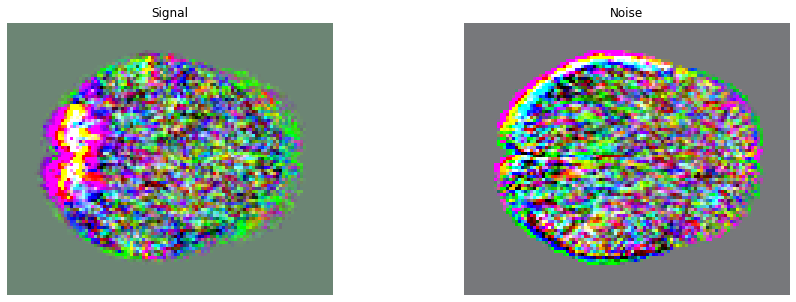

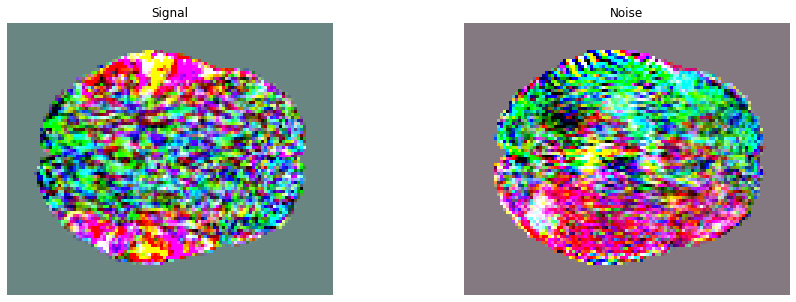

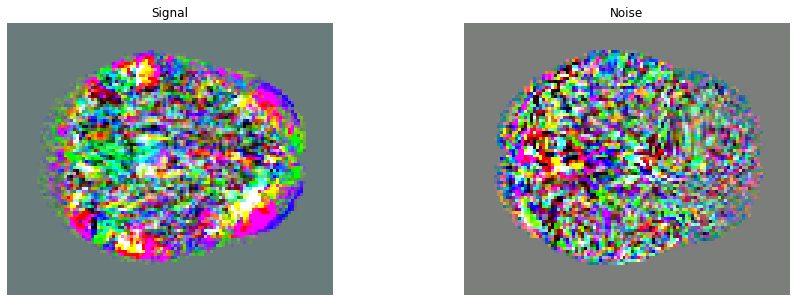

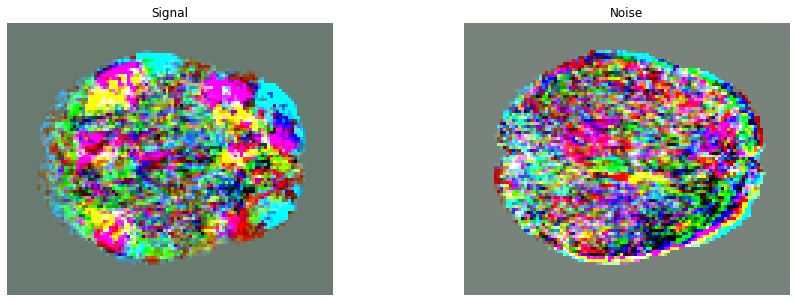

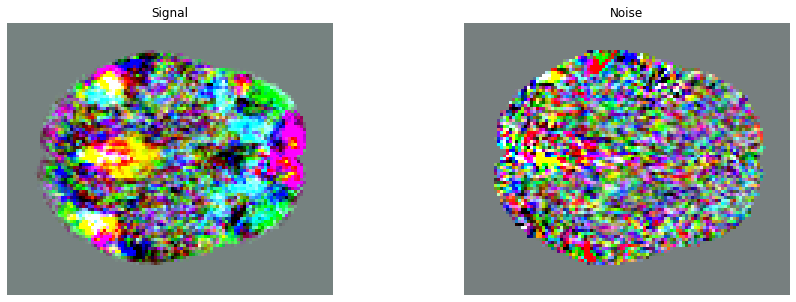

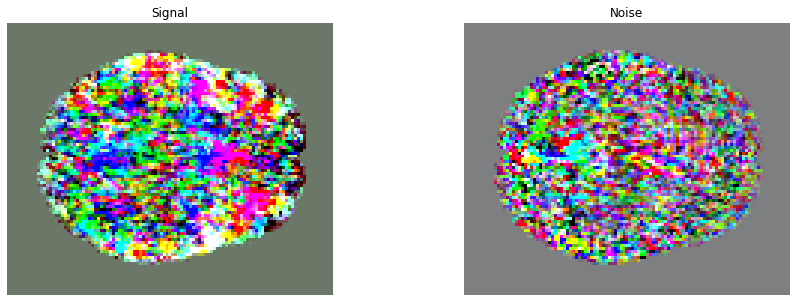

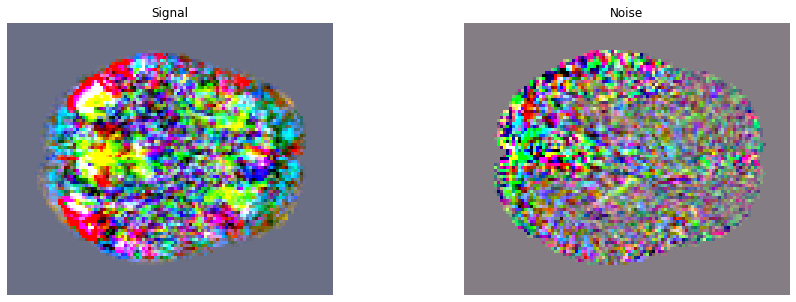

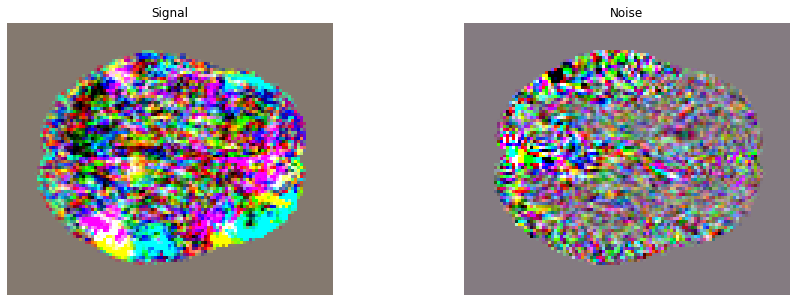

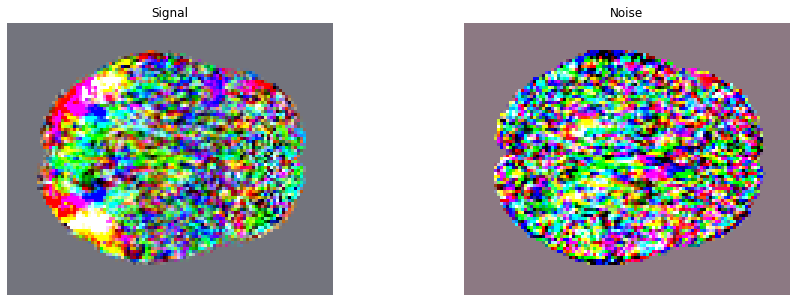

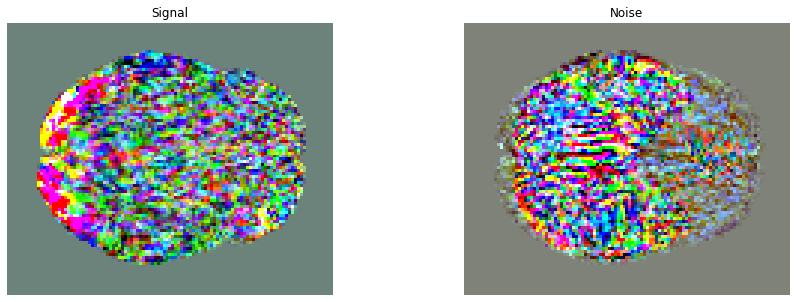

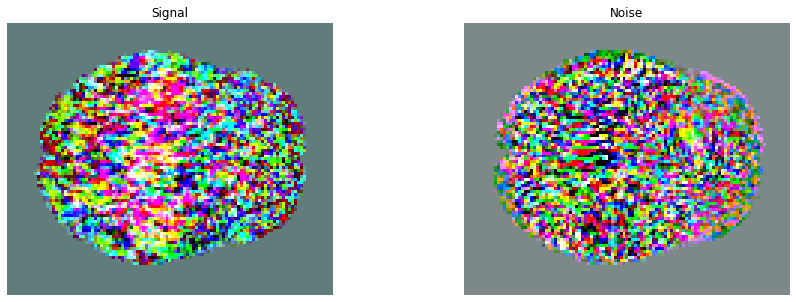

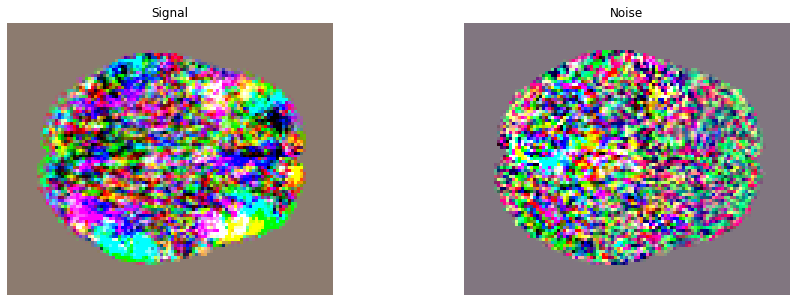

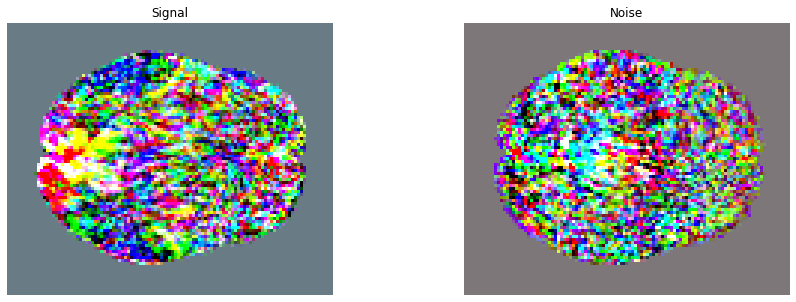

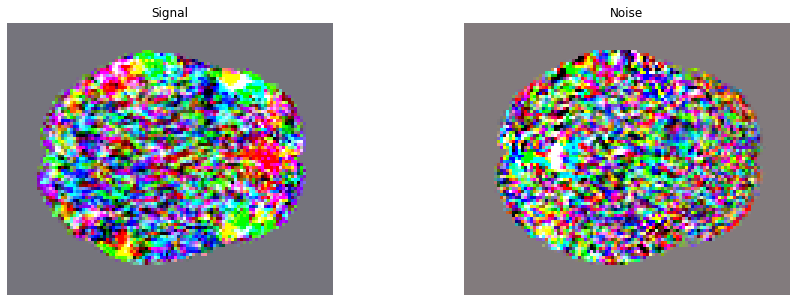

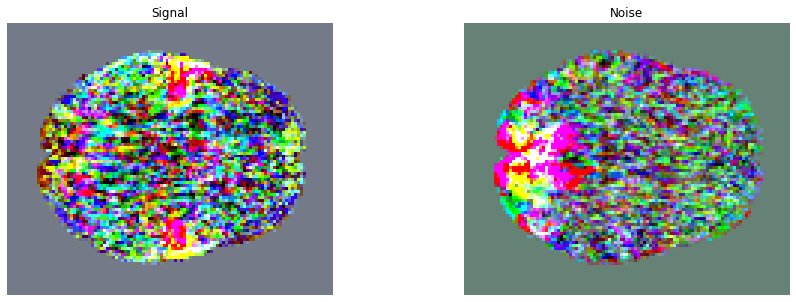

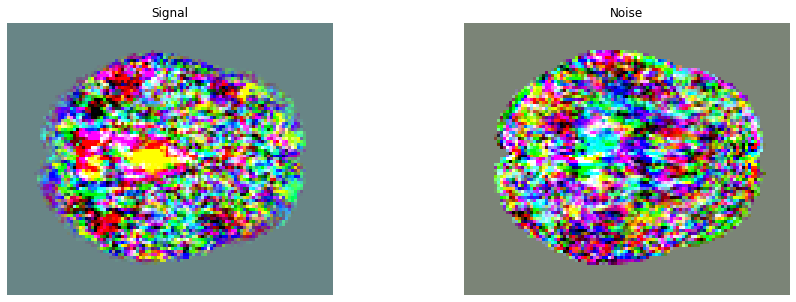

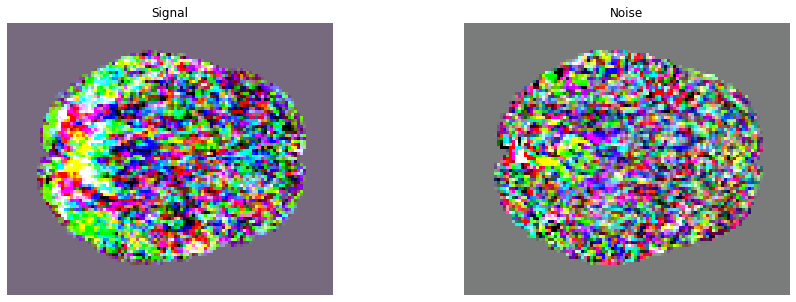

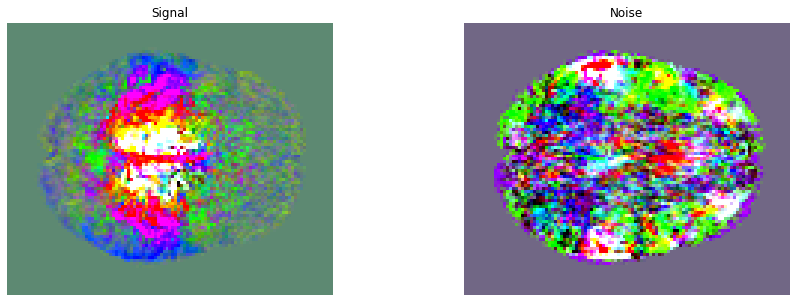

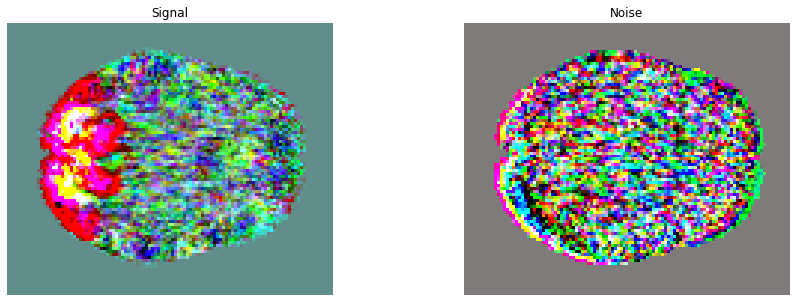

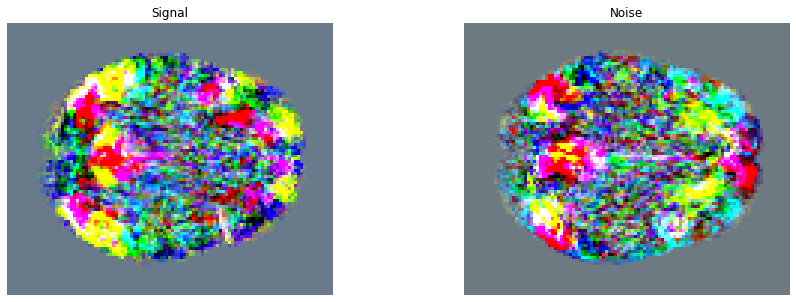

In [17]:
for j in range(20):
  ima1=cv2.imread(Orde[Signal[20+j]].strip())[:,:109,:]
  ima2=cv2.imread(Orde[20+j].strip())[:,:109,:]

  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.imshow(ima1)
  plt.title('Signal')
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.imshow(ima2)
  plt.title('Noise')
  plt.axis('off')

In [19]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS=np.shape(ima1)
#IMG_WIDTH=109
print(np.shape(ima1))

(91, 109, 3)


In [0]:
M_train = np.zeros((len(TRAIN_PATH), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
for n in range(len(TRAIN_PATH)):
  name=TRAIN_PATH[n].strip()
  ima=cv2.imread(name)[:,:109,:]
  #ima=cv2.medianBlur(ima, 7)
  ima=np.array(ima)
  M_train[n]=ima

In [0]:
M_test = np.zeros((len(TEST_PATH), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
for n in range(len(TEST_PATH)):
  name=TEST_PATH[n].strip()
  ima=cv2.imread(name)[:,:109,:]
  #ima=cv2.medianBlur(ima, 7)
  ima=np.array(ima)
  M_test[n]=ima

In [22]:
print('training data   ', x_train.shape)
print('test data       ', x_test.shape)

print('training labels ', y_train.shape)
print('test labels     ', y_test.shape)

print('training maps   ', M_train.shape)
print('test maps       ', M_test.shape)

training data    (18301, 6)
test data        (4576, 6)
training labels  (18301,)
test labels      (4576,)
training maps    (18301, 91, 109, 3)
test maps        (4576, 91, 109, 3)


In [0]:
reg=0.4
nb_classes=2

In [0]:
#funcion para establecer el modelo
def get_model():
    tf.reset_default_graph()
    tf.keras.backend.clear_session()    
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) #Capa de entrada
    s = Lambda(lambda x: x / 255) (inputs)                #Capa no entrenable o funcion (normaliza las ima)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s) #convolucion
    c1 = Dropout(reg) (c1)                                                                        #regularizacion 0
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)#convolucion
    c1 = MaxPooling2D((2, 2)) (c1)                                                                #reduccion de dim    
    c6 = Flatten()(c1)
    
    c6 = Dense(16, activation='relu')(c6)
    c6 = Dropout(reg)(c6)    
    c6 = Dense(8, activation='relu')(c6)
    c6 = Dropout(reg)(c6)    
    c6 = Dense(4, activation='relu')(c6)
    c6 = Dropout(reg)(c6)    
       
    outputs = Dense(nb_classes, activation='softmax')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])    
    return model

In [25]:
model = get_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91, 109, 3)]      0         
_________________________________________________________________
lambda (Lambda)              (None, 91, 109, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 109, 16)       448       
_________________________________________________________________
dropout (Dropout)            (None, 91, 109, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 91, 109, 16)       2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 54, 16)        0         
______________________________________________

In [26]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('drive/My Drive/DatosDeepLearning/PCA-axial.h5', verbose=1, save_best_only=True)
results = model.fit(M_train, y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystopper, checkpointer])

Train on 16470 samples, validate on 1831 samples
Epoch 1/50
16400/16470 [============================>.] - ETA: 0s - loss: 0.4324 - acc: 0.8992
Epoch 00001: val_loss improved from inf to 0.34110, saving model to drive/My Drive/DatosDeepLearning/PCA-axial.h5
16470/16470 [==============================] - 13s 814us/sample - loss: 0.4317 - acc: 0.8994 - val_loss: 0.3411 - val_acc: 0.8951
Epoch 2/50
16416/16470 [============================>.] - ETA: 0s - loss: 0.3334 - acc: 0.8994
Epoch 00002: val_loss improved from 0.34110 to 0.33805, saving model to drive/My Drive/DatosDeepLearning/PCA-axial.h5
16470/16470 [==============================] - 10s 591us/sample - loss: 0.3335 - acc: 0.8994 - val_loss: 0.3381 - val_acc: 0.8951
Epoch 3/50
16416/16470 [============================>.] - ETA: 0s - loss: 0.3301 - acc: 0.8994
Epoch 00003: val_loss improved from 0.33805 to 0.33594, saving model to drive/My Drive/DatosDeepLearning/PCA-axial.h5
16470/16470 [==============================] - 11s 638us

In [27]:
test_preds = model.predict(M_test).argmax(axis=1)
Accuracy = np.mean(test_preds == y_test)
print(Accuracy)

0.8957604895104895


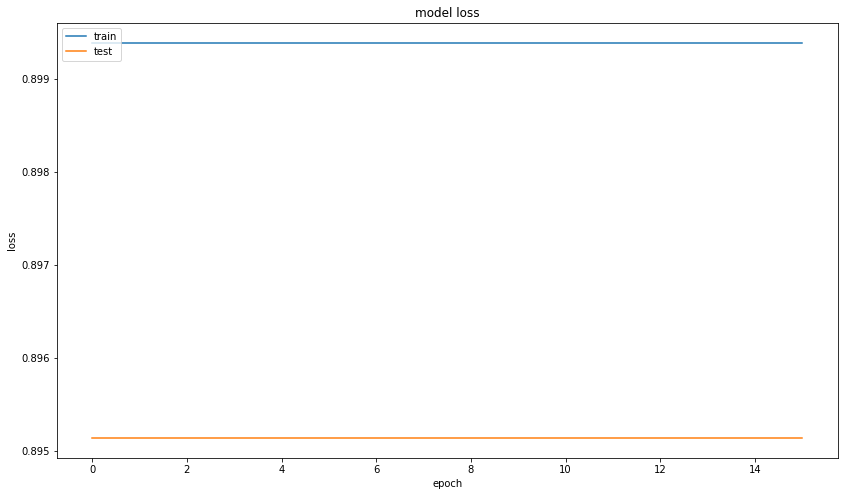

In [28]:
#%matplotlib inline
plt.figure(figsize=(14,8))
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()